In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

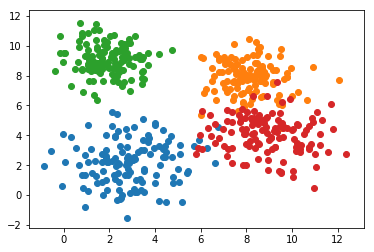

In [2]:
def createDataset(k, means, std, size=500):
    data = np.empty( (0,3) )
    for cluster in range(k):
        pts = np.random.normal(means[cluster], std[cluster], size=(size//k,2))
        pts = np.c_[pts, np.ones(size//k)*cluster ]
        data = np.append( data, pts, axis=0)
    np.random.shuffle(data)
    return data
data = createDataset( 4, [ (3,2), (8,8), (2,9), (9,4) ], [ 1.5, 1.1, 1, 1.4] )
for k in range(4):
    temp = data[:,0:2][data[:,2]==k]
    plt.scatter( temp[:,0], temp[:,1],  )

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split( data[:,0:2],data[:,2],test_size=0.2, stratify=data[:,2] )
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((400, 2), (100, 2), (400,), (100,))

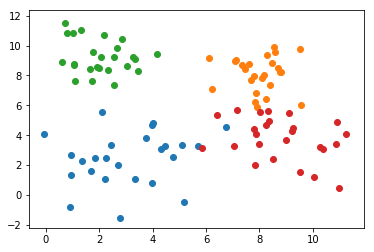

In [4]:
#our test data
for k in range(4):
    temp = X_test[Y_test==k]
    plt.scatter( temp[:,0], temp[:,1],  )

#### Euclidean Distance

$ d = \sqrt{ \sum_{i=0}^{k} \big(X_i - Y_i \big)^2 } $

In [5]:
def distance( X1,X2 ):
    return np.sqrt( np.sum( (X1-X2)**2, axis=1) )

In [6]:
def areCentersChanged(new,old):
    "check if centers are changed"
    for n,o in zip(new,old):
        if n!=o: return True
    return False

def getNewMeans( k, data, initial_centers ):
    newCluster = np.empty((len(data),0))
    #find distance from each cluster mean
    for i in range(k):
        newCluster = np.c_[ newCluster, distance(data,np.array(initial_centers[i])) ]
    #get cluster name
    newCluster = np.argmin(newCluster,axis=1)
    new_means = []
    #get new means
    for i in range(k):
        newPoints = X_train[newCluster==i]
        if len(newPoints)==0: new_means.append( initial_centers[i])
        else: new_means.append( tuple( newPoints.mean(axis=0) )  )
    return new_means

#### K-Means ++
K-Means++ is a smart way to select initial cluster centers. It also helps to optimize K-Means faster.

But, here we are using random initialization only.

In [7]:
def getRandomCenters(data,k):
    X = np.random.randint( data[:,0].min(), data[:,0].max(), size=k )
    Y = np.random.randint( data[:,1].min(), data[:,1].max(), size=k )
    return [ (x,y) for x,y in zip(X,Y) ]
initial_centers = getRandomCenters(X_train,4)

In [8]:
old_centers = [None]*len(initial_centers)
i=1
while areCentersChanged(initial_centers,old_centers):
    print(f'Iteration {i}');i+=1
    old_centers = initial_centers
    initial_centers = getNewMeans( 4, X_train, initial_centers)
print(f'Clusters Centers Found : {initial_centers}')

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Clusters Centers Found : [(8.890800746480751, 4.028562249563796), (2.7563546222529247, 2.1017569661528372), (8.155661785267371, 7.919779590700222), (1.9230910561465666, 9.01188633291469)]


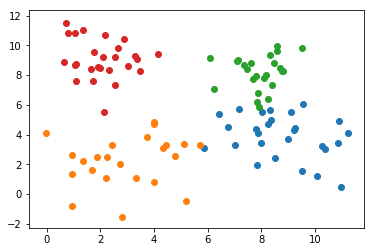

In [9]:
def getClusters( data, centers ):
    cluster = np.empty((len(data),0))
    for i in range(len(centers)):
        cluster = np.c_[ cluster, distance(data,np.array(centers[i])) ]
    return np.argmin(cluster,axis=1)
cluster = getClusters(X_test,initial_centers)
for i in range(4):
    plt.scatter( X_test[:,0][cluster==i], X_test[:,1][cluster==i] )

#### Adjusted Rand Score
It is a metric which computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [10]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(Y_test, cluster,)

0.9192643754680869

#### Elbow Method
1. It is a method to find number of cluster that are possible in given data.
2. Uses sum of squared distances vs number of clusters.
3. When the plot takes a sharp curve (creates a elbow). That is optimal number of cluster.
4. This means increasing number of cluster center is not having much impact on overall distance form center.

Text(0.5,1,'Elbow Curve')

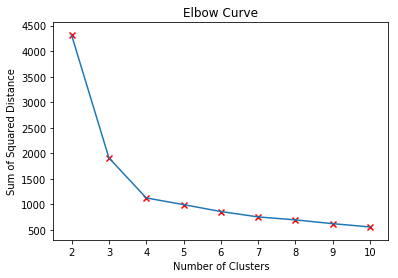

In [11]:
ssd = []
K = [2,3,4,5,6,7,8,9,10]
for k in K:
    new = getRandomCenters(X_train,k)
    old = [None]*len(new)
    while areCentersChanged(new,old):
        old = new
        new = getNewMeans( k, X_train, new)
    cluster = getClusters(X_train,new)
    temp = 0
    for i in range(k):
        temp += np.sum( np.square(distance(X_train[cluster==i], np.array(new[i]))))
    ssd.append(temp)
plt.plot(K,ssd)
for k,s in zip(K,ssd): plt.scatter( k,s, marker='x', c='r' )
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distance')
plt.title('Elbow Curve')

Here, K=4 is experiencing a sharp curve, So 4 is optimal number of clusters.